<a href="https://colab.research.google.com/github/Aerospace87/ML-projects/blob/main/tensorflow/Text_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [85]:
from google.colab import drive

# Mount your Google Drive to the local /content/drive directory
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [86]:
from os import listdir, path

local_folder = "/content/drive/My Drive/"

with open(path.join(local_folder ,"dataset/shakespeare.txt")) as f:
  shakespeare_dataset = f.read()

In [87]:
shakespeare_dataset = shakespeare_dataset.replace("THE SONNETS\n\nby William Shakespeare\n\n", "")

In [88]:
shakespeare_dataset = list(shakespeare_dataset)

In [89]:
characters_list = list(set(shakespeare_dataset))

In [90]:
seq_length = 100

def create_sequences(seq_length, text):
  if isinstance(text, str):
    text = text.split()

  # This because the output sequence is shifted one token
  # to the right.For Example:
  # chunk = Hello; Input: Hell ; Output: ello
  chunk_length = 1 + seq_length


  num_sequences = len(text) // chunk_length

  if len(text) % chunk_length != 0:
    remainder = len(text) % chunk_length
  else:
    remainder = 0

  sequences = []

  if remainder == 0:
    for ii in range(num_sequences):
      sequences[ii] = [text[ii*chunk_length: (ii+1)* chunk_length]]
  else:
    for ii in range(num_sequences):
      sequences.append(  text[ii*chunk_length: (ii+1)* chunk_length] )

    sequences.append(text[num_sequences * chunk_length: num_sequences * chunk_length + remainder - 1])

  return sequences

shakespeare_dataset = create_sequences(seq_length, shakespeare_dataset)

In [91]:
len(shakespeare_dataset)

934

## Cleaning the dataset and spliting into training examples and lables

In [92]:
dataset = ["".join(doc[:-1]) for doc in shakespeare_dataset]
labels = ["".join(doc[1:]) for doc in shakespeare_dataset]

In [93]:
number_documents = len(dataset)

## Split dataset into a training an validation set

In [94]:
training_percentage = 80

training_samples = (number_documents * training_percentage) // 100
validation_samples = number_documents - training_samples

X_train = dataset[:training_samples]
Y_train = labels[:training_samples]

X_val = dataset[training_samples:]
Y_val = labels[training_samples:]

In [95]:
test = X_train[0]

## Text Vectorization

In [96]:
from tensorflow.keras import layers

# character options permits to separate each character
text_vectorization = layers.TextVectorization(
    split='character',
    output_mode='int',
    standardize = None,
    vocabulary = characters_list
)

In [97]:
dataset = text_vectorization(dataset)

In [98]:
# Dictionay to map back from integer index to word
from_int_to_word ={}
from_word_to_int = {}
vocabulary = text_vectorization.get_vocabulary()
vocabulary_size = len(vocabulary)

for idx,word in enumerate(vocabulary):
    from_int_to_word[idx] = word
    from_word_to_int[word] = idx

In [99]:
labels = text_vectorization(labels)

In [100]:
X_train = text_vectorization(X_train)
Y_train = text_vectorization(Y_train)
X_val = text_vectorization(X_val)
Y_val = text_vectorization(Y_val)

In [101]:
X_train[0].numpy()

array([12, 51, 43, 36, 52,  8, 44, 27, 51, 23, 53, 37, 52, 30, 51, 23, 44,
       37, 35, 51, 23, 53, 52, 39, 23, 52, 42, 23, 53, 27, 51, 23, 52, 27,
       59, 30, 51, 23, 44, 53, 23, 17, 20, 49, 11, 44, 37, 52, 37, 11, 23,
       51, 23, 13, 40, 52, 13, 23, 44, 35, 37, 40, 15, 53, 52, 51, 43, 53,
       23, 52, 36, 27, 60, 11, 37, 52, 59, 23,  5, 23, 51, 52, 42, 27, 23,
       17, 20, 45, 35, 37, 52, 44, 53, 52, 37, 11, 23, 52, 51, 27])

In [102]:
Y_train[0].numpy()

array([51, 43, 36, 52,  8, 44, 27, 51, 23, 53, 37, 52, 30, 51, 23, 44, 37,
       35, 51, 23, 53, 52, 39, 23, 52, 42, 23, 53, 27, 51, 23, 52, 27, 59,
       30, 51, 23, 44, 53, 23, 17, 20, 49, 11, 44, 37, 52, 37, 11, 23, 51,
       23, 13, 40, 52, 13, 23, 44, 35, 37, 40, 15, 53, 52, 51, 43, 53, 23,
       52, 36, 27, 60, 11, 37, 52, 59, 23,  5, 23, 51, 52, 42, 27, 23, 17,
       20, 45, 35, 37, 52, 44, 53, 52, 37, 11, 23, 52, 51, 27, 54])

In [103]:
# Checking that the translation is ok
test1 = ""
for idx in X_train[0, :].numpy():
  char = from_int_to_word[idx]
  test1 += char

assert test == test1

## Creation of a tensorflow dataset using training examples and labels

In [104]:
from tensorflow.data import Dataset
# Creation of the datasets to feed to the model
train_dataset = Dataset.from_tensor_slices(
    (X_train, Y_train)
)

val_dataset = Dataset.from_tensor_slices(
    (X_val, Y_val)
)

train_size = X_train.shape[0]

# shuffle and split into batches of batch size BATCH_SIZE
BATCH_SIZE = 4

# Buffer size of the buffer to shuffle the dataset
# Otherfwise TF will have the full dataset in memory
BUFFER_SIZE = 10000

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
val_dataset = val_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Model Creation

In [105]:
# Because we need to output the state (which is a tensor) and the output
# then we must use the functional API
from tensorflow.keras import Input, Model
from tensorflow.keras import activations
from tensorflow.keras import layers

In [109]:
class CustomModel(Model):
  def __init__(self, vocabulary_size, embedding_vector_dimension, lstm_units,dropout=0.0, recurrent_dropout=0.0, verbose=False):
    super().__init__()

    self.verbose = verbose

    self.word_embedding = layers.Embedding(
                                          input_dim = vocabulary_size,
                                          output_dim=embedding_vector_dimension
                                          )
    self.lstm1 = layers.LSTM(lstm_units, return_sequences = True, return_state=True,
                             dropout=dropout, recurrent_dropout=recurrent_dropout)

    softmax = activations.softmax

    self.softmax_layer = layers.Dense(units=vocabulary_size, activation = softmax)


  def call (self, inputs, training=False, states1=None):

      embedding = self.word_embedding(inputs)

      if states1 is None:
        states1 = self.lstm1.get_initial_state(embedding)

      seq_output_1, final_memory_state_1, final_carry_state_1 = self.lstm1(embedding, initial_state = states1 )

      states1 = [final_memory_state_1, final_carry_state_1]

      outputs = self.softmax_layer(seq_output_1)

      if self.verbose:
        print(f"Inputs shape : {inputs.shape}")
        print(f"Embedding shape: {embedding.shape}")
        print(f"LSTM1 shape: {seq_output_1.shape}")
        print(f"Softmax shape: {outputs.shape}")

      if training:
        return outputs
      else:
        return outputs, states1


In [111]:
word_embedding_vector_dimension = 32
lstm_units = 1024
model = CustomModel(vocabulary_size, word_embedding_vector_dimension, lstm_units,recurrent_dropout=0.5, verbose=False)

In [112]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy
loss = SparseCategoricalCrossentropy(from_logits=False)

In [113]:
from tensorflow.keras.optimizers import Adam
adam_optimizer = Adam(learning_rate=2e-3)

In [114]:
from tensorflow.keras.metrics import SparseCategoricalAccuracy
metric = SparseCategoricalAccuracy()

In [115]:
model.compile(optimizer = adam_optimizer, loss = loss, metrics=[metric])

## Testing the model works

In [116]:
first_batch = train_dataset.take(1)

In [117]:
for input_data, labels in first_batch:
  predictions = model(input_data,training=True)
  assert predictions.shape == (BATCH_SIZE, seq_length, vocabulary_size)

In [118]:
model.summary()

Model: "custom_model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     multiple                  2016      
                                                                 
 lstm_9 (LSTM)               multiple                  4329472   
                                                                 
 dense_6 (Dense)             multiple                  64575     
                                                                 
Total params: 4396063 (16.77 MB)
Trainable params: 4396063 (16.77 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Configuring checkpoints

In [119]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [120]:
checkpoint_folder = path.join(local_folder,
                              "tf_checkpoints/Text Generation using RNN"
)

checkpoint_files_path = path.join(checkpoint_folder, "ckpt_{epoch}")

EPOCHS = 20
SAVING_FREQUENCY = 100

checkpoint_callback = ModelCheckpoint(
    filepath = checkpoint_files_path,
    save_weights_only=True,
    save_freq="epoch",
    period=SAVING_FREQUENCY

)

## Training

In [121]:
restart = False
restart_epoch = 1000

if restart:
  checkpoint_files_path = path.join(checkpoint_folder, f"ckpt_{restart_epoch}")
  model.load_weights(checkpoint_files_path)

history = model.fit(train_dataset,
                    epochs=EPOCHS,
                    validation_data=val_dataset,
                    callbacks=[checkpoint_callback]
                    )

Epoch 1/20
187/187 [==============================] - 68s 339ms/step - loss: 2.8192 - sparse_categorical_accuracy: 0.2366 - val_loss: 2.2986 - val_sparse_categorical_accuracy: 0.3432
Epoch 2/20
187/187 [==============================] - 62s 334ms/step - loss: 2.1529 - sparse_categorical_accuracy: 0.3662 - val_loss: 2.0755 - val_sparse_categorical_accuracy: 0.3921
Epoch 3/20
187/187 [==============================] - 61s 324ms/step - loss: 1.9351 - sparse_categorical_accuracy: 0.4247 - val_loss: 1.9098 - val_sparse_categorical_accuracy: 0.4322
Epoch 4/20
187/187 [==============================] - 63s 335ms/step - loss: 1.7885 - sparse_categorical_accuracy: 0.4612 - val_loss: 1.8176 - val_sparse_categorical_accuracy: 0.4591
Epoch 5/20
187/187 [==============================] - 62s 329ms/step - loss: 1.6797 - sparse_categorical_accuracy: 0.4879 - val_loss: 1.7717 - val_sparse_categorical_accuracy: 0.4728
Epoch 6/20
187/187 [==============================] - 63s 335ms/step - loss: 1.5975 -

## Plotting Validation and training Loss

In [122]:
import pandas as pd
results = pd.DataFrame.from_dict(history.history)

<Axes: >

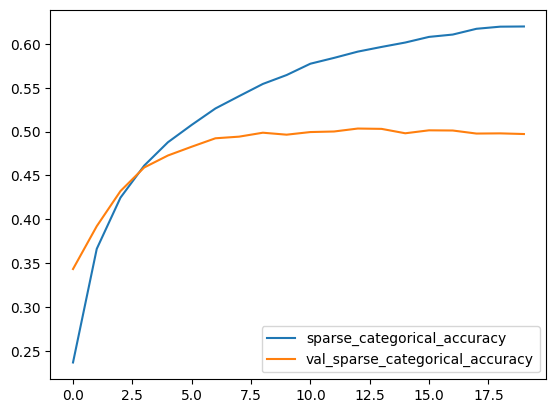

In [129]:
results.plot(y=['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy'], use_index=True)

## Sampling

In [124]:
import numpy as np

In [126]:
char = "T"
states1 = None

number_of_words = 200

sentence = [char]

for ii in range(number_of_words):
  char = [[char]]

  char = text_vectorization(char)

  output, states1 = model(char, states1 = states1)

  char_probabilities = output[:,-1,:].numpy().reshape(-1)

  word_indexes = np.arange(vocabulary_size).reshape(-1)
  next_index = np.random.choice(word_indexes, p= char_probabilities)


  char = from_int_to_word[next_index]

  sentence.append(char)

sentence = ''.join(sentence)

In [127]:
print(sentence)

They did cannot can not,
For never winter's sweet roof love, so fair a lie,
Your self rebair in growth famine eye is a dial hand,
Nor (this accenate to the hearts tell to suh,
And your true converted h
